# Transient ET model - Self Check Example

## Model Description 
This is a transient box model with recharge and Transient ET

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Right boundary is no flow (i.e. a closed basin) 
 - Left boundary is a constant head of 70 m relative to the datum, which is located at the bottom of the domain. 
 - Recharge occurs at a rate of 1E-4 m/d uniformly across the domain
 
#### ET
 - Un-irrigated field with ET
     - Lower left corner (400,900) Upper Right Corner (1500,1600) (locations given as x,y)
     - Extinction depth 100 m
     - Two stressperiods: 0 ET for 30 days followed by 1e-3 ET for 335 days repeated for 16 years within the field.
     - Outside this field the ET is zero for the entire time period.

## 1. Setup the environment

In [1]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/flopy


## 2. Setup the input variables 

In [2]:
## Discritization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x diretion 
dy= 100 #width of grid cells in y diretion 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 100.    #top elevation 
zbot = 0.     #bottom elevation

dz = (ztop - zbot) / nlay #cell height in z direction

## Subsurface properties
K_horiz = 1.    #horizontal hydraulic conductivity 
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## Recharge
recharge = 1e-4 #m/day

#ET

ET_val1 = 0 #m/day
ET_val2 = 1e-3 #m/day
ET_SS = 335*ET_val2/365  #just a random guess
ET_locxy=[[400, 900], [1500, 1600]] #lower left and upper right corners of ET in xy coordinate
extinction_depth = 100

#well - keeping this here just to have an observation point at the  center of the field
pumping = 0 #m3/day  *This rate was figured out from the Water balance of the ET scenario
well_xy=np.average(ET_locxy, axis=0) #xy location of well in center of ET zone
print(well_xy)
well_row = np.floor(nrow-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_loc = (0,well_row,well_col) #Well loc shoudl be layer, row, column
print(well_loc)
#print(well_col)
#well_array = np.zeros()


## Boundary conditions
h_left=70

[ 950. 1250.]
(0, 37.0, 9.0)


### Timing  variables 
These are the added variables for the transient simualtion 
- **nper** is the number of  model stress periods.
- The **steady** variable turns into a list with boolean entries "True/False" for each of these stress periods. The first is designated as "True" in order to set up a steady-state solution for our aquifer to use as a base for future transient stress periods. (If we just start solving transient stress periods with arbitrary starting heads, it wouldn't make for a very realistic natural groundwater system.) More stress periods are added to a simulation if there are changes to the "stress" on the aquifer, i.e. pumping, river levels, or recharge rates. (Note: some things cannot be changed per stress period, i.e. ibound, conductivity, or other properties related to the aquifer geology.)
- **perlen** designates the length of each stress period. For the steady-state stress period, it doesn't really matter what we assign here since the equation is not time-dependent. For the transient stress periods we assign 'perlen' entries that correspond to whatever we have defined our length units to be. For this model, each stress period will last 5 days.
- **nstp** is the number of steps for which MODFLOW's solver will attain solutions within the length of each stress periods. It may be adjusted depending on what you are interested in resolving in the simulation; if you wish to see high resolution changes in head profiles, a higher nstp may be used. However, this will increase the time required to solve the simulation since the solver needs to output more solutions, so if you are just interested in the general head behavior over a large number of stress periods, a lower 'nstp' may be used.

In [3]:
sp_peryr = 2        # periods for seasonality (two stress periods per year)
sp1_len = 30       # Length of stress period 1 in days
sp2_len = 335      # Length of stress period 2 in days
sim_years = 16       #number of years for transient simulation 
nper = int(sp_peryr*sim_years + 1) # total number of stress periods the +1 is for the steady state start

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen/5 #what's this line for???-abe
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", nstp)


Period lengths [ 10  30 335  30 335  30 335  30 335  30 335  30 335  30 335  30 335  30
 335  30 335  30 335  30 335  30 335  30 335  30 335  30 335]
Number of Steps [ 1  6 67  6 67  6 67  6 67  6 67  6 67  6 67  6 67  6 67  6 67  6 67  6
 67  6 67  6 67  6 67  6 67]


## 3. Setup and run a transient MODFLOW for the ET scenario


In [4]:
#Initialize the model
modelnameE = "ET_Model_Question1"
moddir="/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
me = flopy.modflow.Modflow(modelnameE, exe_name = moddir)

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=me, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
#setup initial heads as 1 everywhere and 7 on the left boundary 
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, 0] = h_left    #replace first (left) col with desired head value of 70
bas = flopy.modflow.ModflowBas(me, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(me, laytyp=uncnf, hk=K_horiz, 
                               vka=K_vert, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 

#Recharge -
#Constant recharge throughout the simulation so I'm just repeating the recharge array for the number of stress periods
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge

R = {}                                             # create empty dictionary for recharge fluxes
for p in range(0,nper):                            # loop over stress periods, skipping initial steady state defined above
    R[p]=rech_zone

rch = flopy.modflow.mfrch.ModflowRch(model=me, rech=R, ipakcb=53)     #create rch object
#print(R[2])

# ET
ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = 1                 # assign ET rate to the ET zone


#Setup alternating ET values
ET_val=np.tile([ET_val1, ET_val2],sim_years)
ET_val=np.append(ET_SS,ET_val) #add a period of length 10 at the start for the steady state simulation
print(ET_val)
                      
ET = {}
for p in range(0,nper):    #loop over stress periods
    #print(ET_val[p])
    ET[p]=ET_zone*ET_val[p]
    print(np.sum(ET[p]))

print(len(ET))
#print(ET)
evt = flopy.modflow.mfevt.ModflowEvt(me, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 

#Output control - OC 
oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
#print(np.shape(oc_spd))
oc = flopy.modflow.ModflowOc(model=me, stress_period_data=oc_spd, compact=True)
#print('Output Control \n', oc_spd)


#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=me)

#write the inputs
me.write_input()    

#Run the model 
success, mfoutput = me.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


#print(ET_rows)
#print(ET_cols)

[0.00091781 0.         0.001      0.         0.001      0.
 0.001      0.         0.001      0.         0.001      0.
 0.001      0.         0.001      0.         0.001      0.
 0.001      0.         0.001      0.         0.001      0.
 0.001      0.         0.001      0.         0.001      0.
 0.001      0.         0.001     ]
0.07067123287671233
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
0.0
0.07700000000000001
33
FloPy is using the following  executable to run the model: /Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MOD

 Solving:  Stress period:     5    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    32    Ground-Wa

 Solving:  Stress period:     9    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:    25    Ground-Wa

 Solving:  Stress period:    11    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    60    Ground-Wa

 Solving:  Stress period:    15    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:    21    Ground-Wa

 Solving:  Stress period:    19    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    17    Ground-Wa

 Solving:  Stress period:    21    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:     6    Ground-Wa

 Solving:  Stress period:    25    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:     2    Ground-Wa

 Solving:  Stress period:    29    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:     1    Ground-Wa

 Solving:  Stress period:    33    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    67    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/03/18 19:09:38
 Elapsed run time:  7.665 Seconds

  Normal termination of simulation


# 6. Read in the outputs

### For the ET Scenario

In [5]:
hds = bf.HeadFile(modelnameE+'.hds')                   # reads the binary head file
times = hds.get_times() # returns a list of timesteps
hds2 = bf.HeadFile('ET_Model_CheckET'+'.hds')
times2 = hds2.get_times()
hds3 = bf.HeadFile('ET_Model_Question3'+'.hds')
times3 = hds3.get_times()
#print(times)
#times2 = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]]

#print(times2)

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
head2 = {}
head3 = {}
headobj = flopy.utils.binaryfile.HeadFile(modelnameE+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelnameE+'.cbc') #get flow data as python object
headobj2 = flopy.utils.binaryfile.HeadFile("ET_Model_CheckET"+'.hds') #get head data as python object
budgobj2 = flopy.utils.binaryfile.CellBudgetFile("ET_Model_CheckET"+'.cbc') #get flow data as python object
headobj3 = flopy.utils.binaryfile.HeadFile("ET_Model_Question3"+'.hds') #get head data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
for stress_per, time in enumerate(times2):
    head2['sp%s'%(stress_per)] = headobj2.get_data(totim=time) #append heads to head list for ea stress per
for stress_per, time in enumerate(times3):
    head3['sp%s'%(stress_per)] = headobj3.get_data(totim=time)
    

# 6. Plotting
#### Plot the head at the center of the ET zone

(0, 37.0, 9.0)


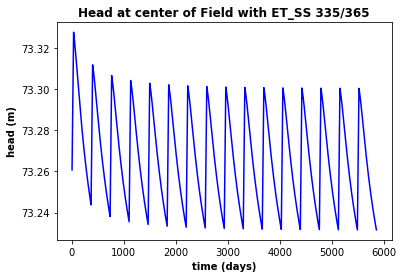

In [6]:
#plot a time series at cell left of river
#get time series for cell
print(well_loc)
cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at center of Field with ET_SS 335/365",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
plt.show()
#plt.savefig("Head_Field_Center_ETSS.png")


### Plot the head at the center of the domain

(0, 24, 24)


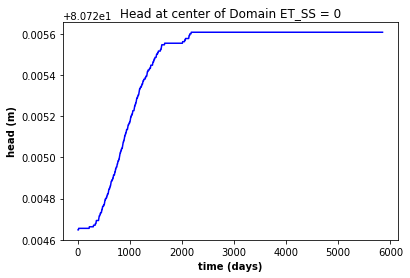

In [7]:

cell_id2 = (0, int(nrow/2) - 1, int(ncol/2) - 1) #cell at the center of the domain
time_series2 = headobj.get_ts(cell_id2) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at center of Domain ET_SS = 0")                   
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series2[:, 0], time_series2[:, 1], 'b-') #plot the time series with points at each record
plt.savefig("Head_Center_Domain.png")

print(cell_id2)


## Plot the head at the end of each stress period 

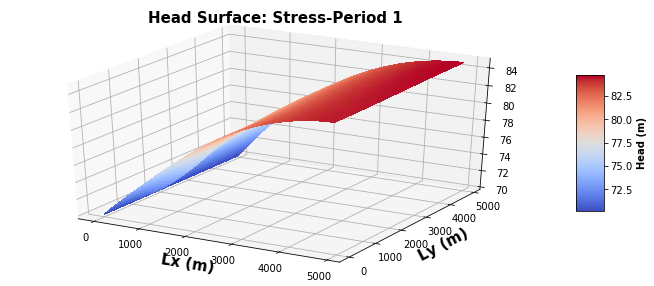

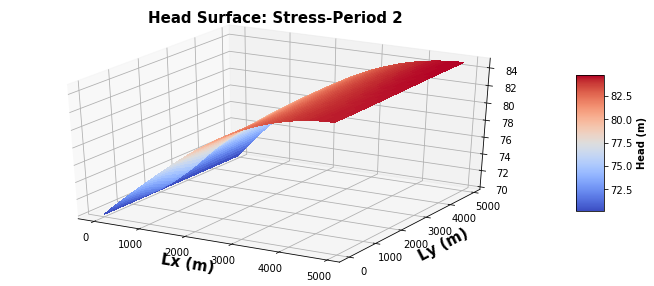

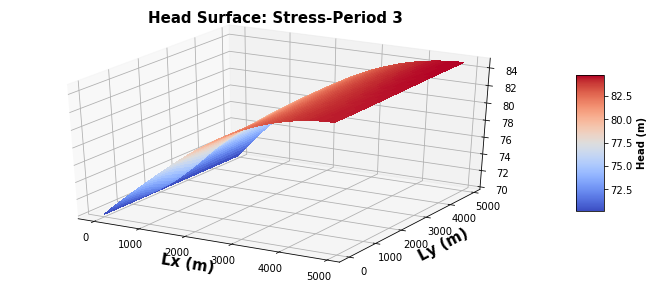

In [8]:
#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
times = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]] #extract times at end of each stress period


#create a figure for every time
for i in range(len(times)):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(head['sp%s'%i][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Head Surface: Stress-Period %s'%(i+1), fontsize=15, fontweight='bold')
    plt.show(surf)

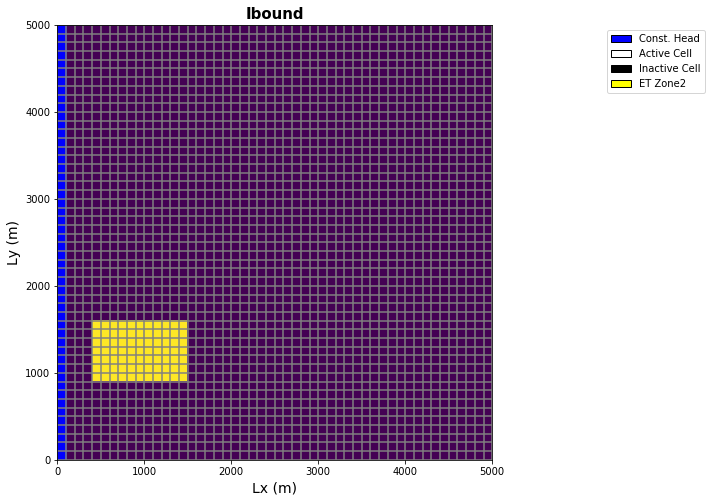

In [9]:
# let's take a look at our grid before making a cross section
#modelmap = flopy.plot.PlotMapView(model=me, layer=0) 
#fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(1, 1, 1, aspect='equal')
#mapview = flopy.plot.PlotMapView(model=me)
#ibound = mapview.plot_ibound()
#quadmesh = modelmap.plot_array(ET_zone)
#quadmesh = modelmap.plot_ibound()
#wel = mapview.plot_bc("WEL")
#riv = mapview.plot_bc("RIV")
#grid = modelmap.plot_grid()
#linecollection = mapview.plot_grid()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=me)
quadmesh = modelmap.plot_array(ET_zone)
quadmesh = modelmap.plot_ibound()
#quadmesh = modelmap.plot_bc('WEL')
grid = modelmap.plot_grid()


#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET Zone2',ec='black')],
                   bbox_to_anchor=(1.5,1.0))

#plt.savefig("modelmap.png")
plt.show(modelmap)

# plotting

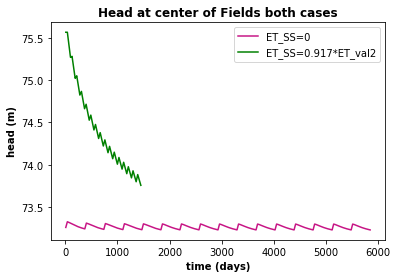

In [10]:
cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy
time_series2 = headobj2.get_ts(cell_id1)
time_series3 = headobj3.get_ts(cell_id1)

plt.subplot(1, 1, 1)
plt.title("Head at center of Fields both cases",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], color='mediumvioletred', label='ET_SS=0') #plot the time series with points at each record
plt.plot(time_series2[:, 0], time_series2[:, 1], color='green', label='ET_SS=0.917*ET_val2')
plt.legend()
plt.show()

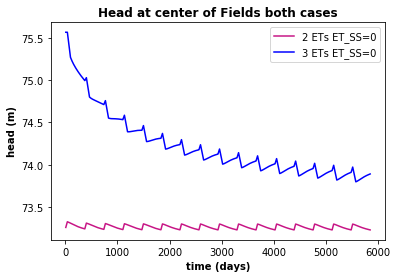

In [14]:
#cell_id1 = well_loc #cell at the center of the ag area
#time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy
#time_series2 = headobj2.get_ts(cell_id1)


#LAST PLOT
plt.subplot(1, 1, 1)
plt.title("Head at center of Fields both cases",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], color='mediumvioletred', label='2 ETs ET_SS=0') #plot the time series with points at each record
#plt.plot(time_series2[:, 0], time_series2[:, 1], color='green', label='ET_SS=0.917*ET_val2')
plt.plot(time_series3[:, 0], time_series3[:, 1], color='blue', label='3 ETs ET_SS=0')



plt.legend()
plt.show()